# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = self.conv(1, 10) #input-28 Output-26 RF-3
        self.conv2 = self.conv(10, 16) #input-26 Output-24 RF-5
        self.conv4 = nn.Conv2d(16, 10, 1, bias=False) #input-24 Output-24 RF-5
        self.pool1 = nn.MaxPool2d(2, 2) #input-24 Output-12 RF-10
        self.conv5 = self.conv(10, 16) #input-12 Output-10 RF-12
        self.conv6 = self.conv(16, 16) #input-10 Output-8 RF-14
        self.conv7 = self.conv(16, 24) #input-8 Output-6 RF-16
        self.conv8 = nn.Conv2d(24, 10, 1, bias=False) #input-8 Output-5 RF-16
        self.gap = nn.AvgPool2d(6) #input-6 Output-1 RF-22

    def conv(self, in_channels, out_channels, padding=0):
      return nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=padding, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(out_channels),
          nn.Dropout(0.05)
      )

    def forward(self, x):
        x = self.pool1(F.relu(self.conv4(self.conv2(self.conv1(x)))))
        x = self.conv8(self.conv7(self.conv6(self.conv5(x))))
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [7]:
# LEAST PARAM MODEL, ADDED 16 CONV IN SECOND BLOCK.
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [8]:
# LEAST PARAM MODEL, ADDED 16 CONV IN SECOND BLOCK. TOP TEST ACC: 99.22%. TRYING TO ADD TO FIRST BLOCK FAILED MISERABLY (TOP TEST ACC 97.60%). IMPLIES THAT 5X5 RF IN FIRST BLOCK WORKS BETTER.
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.14242149889469147 Batch_id=468 Accuracy=88.34: 100%|██████████| 469/469 [00:10<00:00, 43.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1270, Accuracy: 9648/10000 (96.48%)

EPOCH: 2


Loss=0.035349491983652115 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:10<00:00, 43.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9847/10000 (98.47%)

EPOCH: 3


Loss=0.04995736852288246 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:10<00:00, 42.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9834/10000 (98.34%)

EPOCH: 4


Loss=0.029340803623199463 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 42.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


Loss=0.02587546966969967 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:10<00:00, 42.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9877/10000 (98.77%)

EPOCH: 6


Loss=0.03212754800915718 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 42.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9871/10000 (98.71%)

EPOCH: 7


Loss=0.07038893550634384 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:10<00:00, 43.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.018557516857981682 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:11<00:00, 42.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.010360177606344223 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:11<00:00, 41.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.021036090329289436 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 41.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.04552919790148735 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:11<00:00, 41.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.03460388630628586 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:11<00:00, 41.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.00467784283682704 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:11<00:00, 42.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.04289105162024498 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 42.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.03431904688477516 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 42.45it/s]



Test set: Average loss: 0.0249, Accuracy: 9918/10000 (99.18%)



Text(0.5, 1.0, 'Test Accuracy')

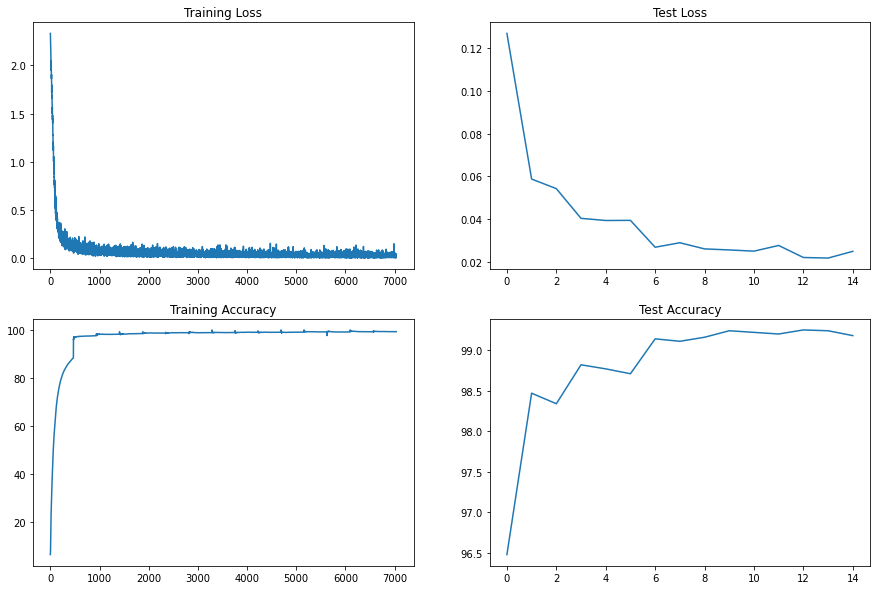

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target - Reduce overfitting by adding regularization and increase validation accuracy.

Results -

Difference between training and validation accuracy is negative most times (implying regularization is making training harder, and forcing parameters to learn better). Therefore, model is able to maintain 99.20%+ validation accuracy consistently.
Max validation accuracy is 99.25%, with respective training accuracy being 99.16%.
Analysis -

Model is being forced to learn better with regularization, pushing validation accuracy.
Augmentation can be used to compensate of different orientations of images in dataset.